In [33]:
from custommodels.SpreadingModels import CascadeModel, ClassicalModel, ThresholdModel, SIRModelBase
from custommodels.Pickle import load
import networkx as nx
import random
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
random.seed(1337)

In [34]:
path = "../data/loc-brightkite_edges.txt.gz"
G = nx.read_edgelist(path, create_using=nx.Graph())
largest_cc = max(nx.connected_components(G), key=len)
len(largest_cc)
G = G.subgraph(largest_cc)

In [35]:
sorted_degree = load('sorted_degree')
betweenness_centrality = load('betweenness_centrality')
sorted_betweenness = sorted(list(betweenness_centrality.items()), key=lambda x: x[1], reverse=True)
print(sorted_degree[:10])
print(sorted_betweenness[:10])
n = 10

Found data, loading from picklejar
Found data, loading from picklejar
[(40, 1134), (44, 1055), (108, 854), (116, 838), (159, 833), (36, 779), (191, 732), (49, 569), (634, 550), (156, 475)]
[(40, 0.12403234435146233), (191, 0.0652084687505221), (159, 0.055154823184804594), (108, 0.048552931583974356), (44, 0.04550912157860133), (36, 0.040196157255756634), (116, 0.04007702651128203), (35, 0.02498508521877784), (49, 0.02024941838392064), (405, 0.016928145463064457)]


In [36]:
def disjoint_sets():
    sorted_betweenness_copy = deepcopy(sorted_betweenness)
    sorted_degree_copy = deepcopy(sorted_degree)
    top_n_deg = []
    top_n_bet = []
    while True:
        if len(top_n_deg) == n and len(top_n_bet) == n:
            break

        deg_candidate = sorted_degree_copy.pop(0)
        bet_candidate = sorted_betweenness_copy.pop(0)

        if str(deg_candidate[0]) == str(bet_candidate[0]):
            continue
        if str(deg_candidate[0]) not in top_n_bet and len(top_n_deg) < n:
            top_n_deg.append(str(deg_candidate[0]))
        if str(bet_candidate[0]) not in top_n_deg and len(top_n_bet) < n:
            top_n_bet.append(str(bet_candidate[0]))
    
    sorted_betweenness_copy = deepcopy(sorted_betweenness)
    sorted_degree_copy = deepcopy(sorted_degree)
    bot_n_deg = []
    bot_n_bet = []
    while True:
        if len(bot_n_deg) == n and len(bot_n_bet) == n:
            break

        deg_candidate = sorted_degree_copy.pop(-1)
        bet_candidate = sorted_betweenness_copy.pop(-1)
        if str(deg_candidate[0]) == str(bet_candidate[0]):
            continue
        if str(deg_candidate[0]) not in bot_n_bet and len(bot_n_deg) < n:
            bot_n_deg.append(str(deg_candidate[0]))
        if str(bet_candidate[0]) not in bot_n_deg and len(bot_n_bet) < n:
            bot_n_bet.append(str(bet_candidate[0]))
    
    return top_n_deg, top_n_bet, bot_n_deg, bot_n_bet

def betweenness_from_nodelist(nl):
    # Returns tuples (node, betweenness)
    return [(node, betweenness_centrality[int(node)]) for node in nl]
def degree_from_nodelist(nl):
    # Returns tuples (node, degree)
    return [(node, G.degree[node]) for node in nl]

In [37]:

top_n_deg, top_n_bet, bot_n_deg, bot_n_bet = disjoint_sets()
top_n_deg, bot_n_deg = degree_from_nodelist(top_n_deg), degree_from_nodelist(bot_n_deg)
top_n_bet, bot_n_bet = betweenness_from_nodelist(top_n_bet), betweenness_from_nodelist(bot_n_bet)
# print(top_n_deg)
# print(top_n_bet)
# print(bot_n_deg)
# print(bot_n_bet)
print(top_n_deg)
print(disjoint_sets()[0])


[('44', 1055), ('108', 854), ('116', 838), ('49', 569), ('634', 550), ('156', 475), ('207', 453), ('651', 448), ('3245', 404), ('250', 386)]
['44', '108', '116', '49', '634', '156', '207', '651', '3245', '250']


In [89]:
def get_starter_degreenodes():
    top_n_degree = [str(node) for node, _ in sorted_degree[:n]]
    bottom_n_degree = [str(node) for node, _ in sorted_degree[-n-1:-1]]
    return top_n_degree, bottom_n_degree

def get_starter_betweennodes():
    top_n_betweenness = [str(node) for node, _ in sorted_betweenness[:n]]
    bottom_n_betweenness = [str(node) for node, _ in sorted_betweenness[-n-1:-1]]
    return top_n_betweenness, bottom_n_betweenness

random_infect = random.sample(list(G.nodes()), n)
random_infect = [str(node) for node in random_infect]

random_recovered = random.sample(list(G.nodes()), n)
random_recovered = [str(node) for node in random_infect]

def get_starter_random(): 
    return random_infect

def get_recovered_random(): 
    return random_recovered

def results_to_noderatios(results, num_initial_infected, G):
    # results is a list of tuples (new_state: dict, newly_infected: list, newly_recovered: list)
    # this turns it into a list of lists, [susceptible: int[], infected: int[], recovered: int[]]
    # the 0th element in each list is the first step, the 1st element is the second step, etc.
    n = len(G.nodes)
    num_susceptible = [n - num_initial_infected]
    num_infected = [num_initial_infected]
    num_recovered = [0]
    for state, i, r in results:
        num_susceptible.append(list(state.values()).count(0))
        num_infected.append(list(state.values()).count(1))
        num_recovered.append(list(state.values()).count(2))
    return np.array(num_susceptible)/n, np.array(num_infected)/n, np.array(num_recovered)/n

# top_n_deg, top_n_bet, bot_n_deg, bot_n_bet
print(random_infect)
print(random_recovered)

['53066', '18289', '1678', '32664', '27149', '1477', '50916', '27240', '51633', '43053']
['53066', '18289', '1678', '32664', '27149', '1477', '50916', '27240', '51633', '43053']


In [39]:
def plot_three_graphs_degree(model: SIRModelBase, title=None, infected=True, susceptible=False, recovered=False, iterations=100, disjoint=False):
    if disjoint:
        top_degree, bottom_degree = disjoint_sets()[0], disjoint_sets()[2]
    else:
        top_degree, bottom_degree = get_starter_degreenodes()
    random = get_starter_random()

    top_degree_model    = deepcopy(model)
    bottom_degree_model = deepcopy(model)
    random_model        = deepcopy(model)

    top_degree_model.set_initial_infected(top_degree)
    bottom_degree_model.set_initial_infected(bottom_degree)
    random_model.set_initial_infected(random)

    top_degree_results    = results_to_noderatios(top_degree_model.iterate(iterations), len(top_degree), G)
    bottom_degree_results = results_to_noderatios(bottom_degree_model.iterate(iterations), len(bottom_degree), G)
    random_results        = results_to_noderatios(random_model.iterate(iterations), len(random), G)
    
    model_results = (top_degree_results, bottom_degree_results, random_results)
    model_names   = (f'Top {len(top_degree)} Degree', f'Bottom {len(bottom_degree)} Degree', f'{len(random)} Random')
    model_colors  = ('red', 'green', 'blue') # for inspiration, see https://matplotlib.org/stable/gallery/color/named_colors.html
    for results, name, color in zip(model_results, model_names, model_colors):
        if infected:
            plt.plot(results[1], label=f"{name} - Infected", color=color, linewidth=2)
        if susceptible:
            plt.plot(results[0], label=f"{name} - Susceptible", color=color, linestyle='dashed', linewidth=2)
        if recovered:
            plt.plot(results[2], label=f"{name} - Recovered", color=color, linestyle='dotted', linewidth=2)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('Fraction of Nodes')
    plt.show()
    return top_degree_results, bottom_degree_results, random_results

# top_n_deg, top_n_bet, bot_n_deg, bot_n_bet

In [40]:
def plot_three_graphs_between(model: SIRModelBase, title=None, infected=True, susceptible=False, recovered=False, iterations=100, disjoint=False):
    if disjoint:
        top_between, bottom_between = disjoint_sets()[1], disjoint_sets()[3]
    else:
        top_between, bottom_between = get_starter_betweennodes()
    random = get_starter_random()

    top_between_model    = deepcopy(model)
    bottom_between_model = deepcopy(model)
    random_model         = deepcopy(model)

    top_between_model.set_initial_infected(top_between)
    bottom_between_model.set_initial_infected(bottom_between)
    random_model.set_initial_infected(random)

    top_between_results    = results_to_noderatios(top_between_model.iterate(iterations), len(top_between), G)
    bottom_between_results = results_to_noderatios(bottom_between_model.iterate(iterations), len(bottom_between), G)
    random_results         = results_to_noderatios(random_model.iterate(iterations), len(random), G)
    
    model_results = (top_between_results, bottom_between_results, random_results)
    model_names   = (f'Top {len(top_between)} Betweenness centrality', f'Bottom {len(bottom_between)} Betweenness centrality', f'{len(random)} Random')
    model_colors  = ('red', 'green', 'blue') # for inspiration, see https://matplotlib.org/stable/gallery/color/named_colors.html
    for results, name, color in zip(model_results, model_names, model_colors):
        if infected:
            plt.plot(results[1], label=f"{name} - Infected", color=color, linewidth=2)
        if susceptible:
            plt.plot(results[0], label=f"{name} - Susceptible", color=color, linestyle='dashed', linewidth=2)
        if recovered:
            plt.plot(results[2], label=f"{name} - Recovered", color=color, linestyle='dotted', linewidth=2)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('Fraction of Nodes')
    plt.show()

    return top_between_results, bottom_between_results, random_results

## Immunitization 

In [90]:
# top_n_deg, top_n_bet, bot_n_deg, bot_n_bet
def plot_immune(model: SIRModelBase, title=None, infected=True, susceptible=False, recovered=False, iterations=100, disjoint=False):
    if disjoint:
        top_degree, top_between, bottom_degree, bottom_between = disjoint_sets()[0], disjoint_sets()[1], disjoint_sets()[2],disjoint_sets()[3]
    else:
        top_between, bottom_between = get_starter_betweennodes()
        top_degree, bottom_degree = get_starter_degreenodes()
    # random nodes to infect
    random_infect = get_starter_random()
    print(random_infect)
    # random nodes to recover 
    random_immune = random.sample(list(G.nodes()), n)
    random_immune = [str(node) for node in random_infect]
    print(random_immune)

    top_between_recovered = deepcopy(model)
    top_degree_recovered = deepcopy(model)
    random_model = deepcopy(model)

    random_model.set_initial_infected(random_infect)
    top_between_recovered.set_initial_infected(random_infect)
    top_degree_recovered.set_initial_infected(random_infect)

    top_between_recovered.set_initial_recovered(top_between)
    top_degree_recovered.set_initial_recovered(top_degree)
    #random_model.set_initial_recovered(random_immune)



    random_results = results_to_noderatios(random_model.iterate(iterations), len(random_infect), G)
    top_between_results    = results_to_noderatios(top_between_recovered.iterate(iterations), len(top_between), G)
    top_degree_results = results_to_noderatios(top_degree_recovered.iterate(iterations), len(top_degree), G)

    model_results = (top_between_results, top_degree_results, random_results)

    model_names   = (f'Top {len(top_between)} Betweenness centrality', f'Top {len(top_degree)} Degree', f'{len(random_infect)} Random')
    model_colors  = ('red', 'green', 'blue') # for inspiration, see https://matplotlib.org/stable/gallery/color/named_colors.html
    for results, name, color in zip(model_results, model_names, model_colors):
        if infected:
            plt.plot(results[1], label=f"{name} - Immune", color=color, linewidth=2)
        if susceptible:
            plt.plot(results[0], label=f"{name} - Susceptible", color=color, linestyle='dashed', linewidth=2)
        if recovered:
            plt.plot(results[2], label=f"{name} - Recovered", color=color, linestyle='dotted', linewidth=2)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('Fraction of Nodes')
    plt.show()

    return top_between_results, top_degree_results, random_results

# Cascade

In [ ]:
def cascade_plot():
    model_between = CascadeModel(G)
    beta, gamma = 0.1, 0.05
    model_between.set_parameters(beta, gamma)

    betw_top, betw_bot, betw_rnd = plot_three_graphs_between(
        model_between, 
        title='Cascade Model Betweenness Centrality', 
        iterations=50,
        infected=True,
        # susceptible=True,
        # recovered=False
    )

    model_degree = CascadeModel(G)
    model_degree.set_parameters(beta, gamma)

    degr_top, degr_bot, degr_rnd = plot_three_graphs_degree(
        model_degree, 
        title='Cascade Model Degree', 
        iterations=50,
        infected=True,
        # susceptible=False,
        # recovered=True
    )

    return betw_top, betw_bot, betw_rnd, degr_top, degr_bot, degr_rnd
cascade_betw_top, cascade_betw_bot, cascade_betw_rnd, cascade_degr_top, cascade_degr_bot, cascade_degr_rnd = cascade_plot()

In [ ]:
cascade_max_topdegree, cascade_time_step_topdegree = max(cascade_degr_top[1]), np.argmax(cascade_degr_top[1])
cascade_max_bottomdegree, cascade_time_step_bottomdegree = max(cascade_degr_bot[1]), np.argmax(cascade_degr_bot[1])

cascade_max_topbetween, cascade_time_step_topbetween = max(cascade_betw_top[1]), np.argmax(cascade_betw_top[1])
cascade_max_bottombetween, time_step_bottombetween = max(cascade_betw_bot[1]), np.argmax(cascade_betw_bot[1])

cascade_max_random, cascade_time_step_random = max(cascade_betw_rnd[1]), np.argmax(cascade_betw_rnd[1])

print('Top degree:',cascade_max_topdegree, cascade_time_step_topdegree)
print('Bottom degree:',cascade_max_bottomdegree, cascade_time_step_bottomdegree)
print('Top betweenness:',cascade_max_topbetween, cascade_time_step_topbetween)
print('Bottom betweenness:',cascade_max_bottombetween, time_step_bottombetween)
print('Random:',cascade_max_random, cascade_time_step_random)




Top degree: 0.8795008724157987 6
Bottom degree: 0.8799943601402915 21
Top betweenness: 0.8755177214966777 6
Bottom betweenness: 0.8789016373217716 21
Random: 0.8537513879342251 18


# Threshold

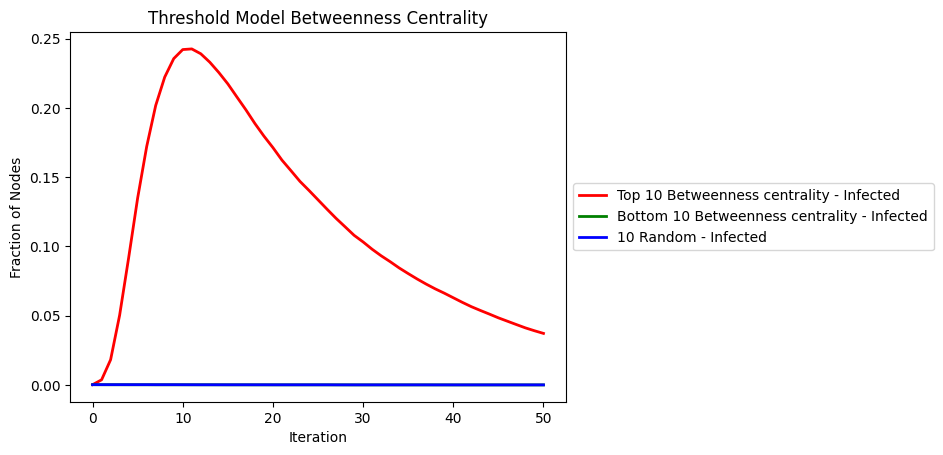

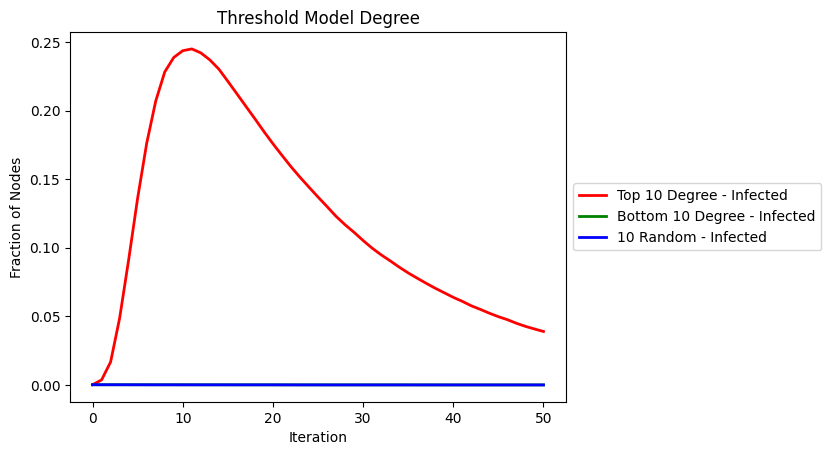

In [ ]:
def threshold_plot():
    model_between = ThresholdModel(G)
    theta, beta, gamma = 3, 0.4, 0.05
    model_between.set_parameters(theta, beta, gamma)

    betw_top, betw_bot, betw_rnd = plot_three_graphs_between(
        model_between, 
        title='Threshold Model Betweenness Centrality', 
        iterations=50,
        infected=True,
        # susceptible=True,
        #recovered=False
    )

    model_degree = ThresholdModel(G)
    model_degree.set_parameters(theta, beta, gamma)

    degr_top, degr_bot, degr_rnd = plot_three_graphs_degree(
        model_degree, 
        title='Threshold Model Degree', 
        iterations=50,
        infected=True,
        # susceptible=False,
        # recovered=True
    )
    return degr_top, degr_bot, degr_rnd, betw_top, betw_bot, betw_rnd
threshold_betw_top, threshold_betw_bot, threshold_betw_rnd, threshold_degr_top, threshold_degr_bot, threshold_degr_rnd = threshold_plot()

In [ ]:
threshold_max_topdegree, threshold_time_step_topdegree = max(threshold_degr_top[1]), np.argmax(threshold_degr_top[1])
threshold_max_bottomdegree, threshold_time_step_bottomdegree = max(threshold_degr_bot[1]), np.argmax(threshold_degr_bot[1])

threshold_max_topbetween, threshold_time_step_topbetween = max(threshold_betw_top[1]), np.argmax(threshold_betw_top[1])
threshold_max_bottombetween, time_step_bottombetween = max(threshold_betw_bot[1]), np.argmax(threshold_betw_bot[1])

threshold_max_random, threshold_time_step_random = max(threshold_betw_rnd[1]), np.argmax(threshold_betw_rnd[1])

print('Top degree:',threshold_max_topdegree, threshold_time_step_topdegree)
print('Bottom degree:',threshold_max_bottomdegree, threshold_time_step_bottomdegree)
print('Top betweenness:',threshold_max_topbetween, threshold_time_step_topbetween)
print('Bottom betweenness:',threshold_max_bottombetween, time_step_bottombetween)
print('Random:',threshold_max_random, threshold_time_step_random)

Top degree: 0.24267258851936058 11
Bottom degree: 0.00017624561589030472 0
Top betweenness: 0.2448756587179894 11
Bottom betweenness: 0.00017624561589030472 0
Random: 0.00017624561589030472 0


# Classical 

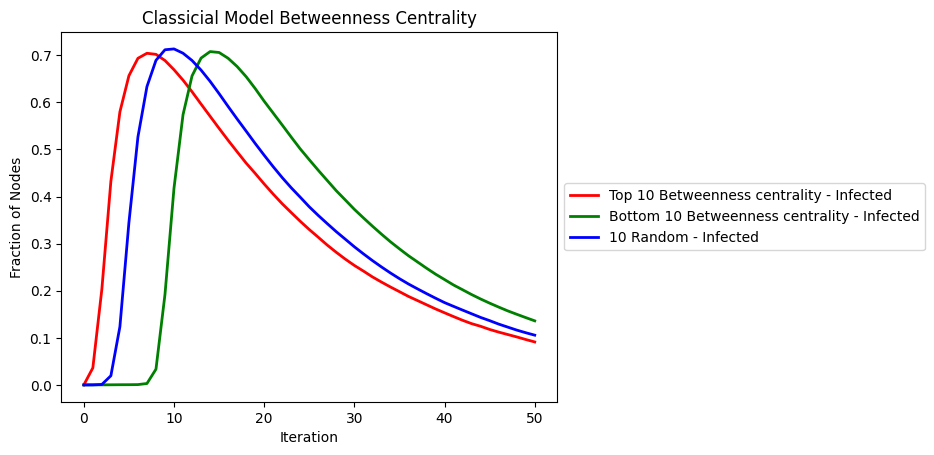

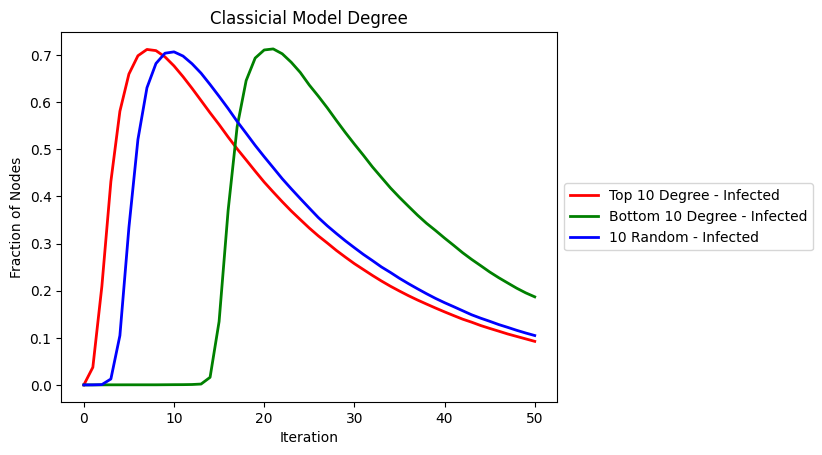

In [ ]:
def classical_plot():
    model_between = ClassicalModel(G)
    beta, gamma = 0.3, 0.05
    model_between.set_parameters(beta, gamma)

    betw_top, betw_bot, betw_rnd= plot_three_graphs_between(
        model_between, 
        title='Classicial Model Betweenness Centrality', 
        iterations=50,
        infected=True,
        # susceptible=True,
        # recovered=False
    )

    model_degree = ClassicalModel(G)
    model_degree.set_parameters(beta, gamma)

    degr_top, degr_bot, degr_rnd = plot_three_graphs_degree(
        model_degree, 
        title='Classicial Model Degree', 
        iterations=50,
        infected=True,
        # susceptible=False,
        # recovered=True
    )
    return degr_top, degr_bot, degr_rnd, betw_top, betw_bot, betw_rnd

classical_betw_top, classical_betw_bot, classical_betw_rnd, classical_degr_top, classical_degr_bot, classical_degr_rnd = classical_plot()

In [ ]:
classical_max_topdegree, classical_time_step_topdegree = max(classical_degr_top[1]), np.argmax(classical_degr_top[1])
classical_max_bottomdegree, classical_time_step_bottomdegree = max(classical_degr_bot[1]), np.argmax(classical_degr_bot[1])

classical_max_topbetween, classical_time_step_topbetween = max(classical_betw_top[1]), np.argmax(classical_betw_top[1])
classical_max_bottombetween, time_step_bottombetween = max(classical_betw_bot[1]), np.argmax(classical_betw_bot[1])

classical_max_random, classical_time_step_random = max(classical_betw_rnd[1]), np.argmax(classical_betw_rnd[1])

print('Top degree:',classical_max_topdegree, classical_time_step_topdegree)
print('Bottom degree:',classical_max_bottomdegree, classical_time_step_bottomdegree)
print('Top betweenness:',classical_max_topbetween, classical_time_step_topbetween)
print('Bottom betweenness:',classical_max_bottombetween, time_step_bottombetween)
print('Random:',classical_max_random, classical_time_step_random)

Top degree: 0.703924989865877 7
Bottom degree: 0.7075204004300393 14
Top betweenness: 0.7117150460882286 7
Bottom betweenness: 0.7128253934683375 21
Random: 0.7065862986658207 10


In [ ]:
def classical_plot_disjoint():
    model_between = ClassicalModel(G)
    beta, gamma = 0.4, 0.05
    model_between.set_parameters(beta, gamma)

    betw_top, betw_bot, betw_rnd= plot_three_graphs_between(
        model_between, 
        title='Classicial Model Betweenness Centrality', 
        iterations=50,
        infected=True,
        # susceptible=True,
        #recovered=True,
        disjoint=True
    )

    model_degree = ClassicalModel(G)
    model_degree.set_parameters(beta, gamma)

    degr_top, degr_bot, degr_rnd = plot_three_graphs_degree(
        model_degree, 
        title='Classicial Model Degree', 
        iterations=50,
        infected=True,
        # susceptible=False,
        #recovered=True,
        disjoint = True
    )
    return degr_top, degr_bot, degr_rnd, betw_top, betw_bot, betw_rnd

classical_betw_top_disjoint, classical_betw_bot_disjoint, classical_betw_rnd_disjoint, classical_degr_top_disjoint, classical_degr_bot_disjoint, classical_degr_rnd_disjoint = classical_plot_disjoint()

In [ ]:
classical_max_topdegree_disjoint, classical_time_step_topdegree_disjoint = max(classical_degr_top_disjoint[1]), np.argmax(classical_degr_top_disjoint[1])
classical_max_bottomdegree_disjoint, classical_time_step_bottomdegree_disjoint = max(classical_degr_bot_disjoint[1]), np.argmax(classical_degr_bot_disjoint[1])

classical_max_topbetween_disjoint, classical_time_step_topbetween_disjoint = max(classical_betw_top_disjoint[1]), np.argmax(classical_betw_top_disjoint[1])
classical_max_bottombetween_disjoint, time_step_bottombetween_disjoint = max(classical_betw_bot_disjoint[1]), np.argmax(classical_betw_bot_disjoint[1])

classical_max_random_disjoint, classical_time_step_random_disjoint = max(classical_betw_rnd_disjoint[1]), np.argmax(classical_betw_rnd_disjoint[1])

print('Top degree:',classical_max_topdegree_disjoint, classical_time_step_topdegree_disjoint)
print('Bottom degree:',classical_max_bottomdegree_disjoint, classical_time_step_bottomdegree_disjoint)
print('Top betweenness:',classical_max_topbetween_disjoint, classical_time_step_topbetween_disjoint)
print('Bottom betweenness:',classical_max_bottombetween_disjoint, time_step_bottombetween_disjoint)
print('Random:',classical_max_random_disjoint, classical_time_step_random_disjoint)

Top degree: 0.7605703308130211 6
Bottom degree: 0.7609228220448017 14
Top betweenness: 0.7581205167521458 7
Bottom betweenness: 0.7602002150196514 14
Random: 0.7618040501242531 8


['53066', '18289', '1678', '32664', '27149', '1477', '50916', '27240', '51633', '43053']
['53066', '18289', '1678', '32664', '27149', '1477', '50916', '27240', '51633', '43053']


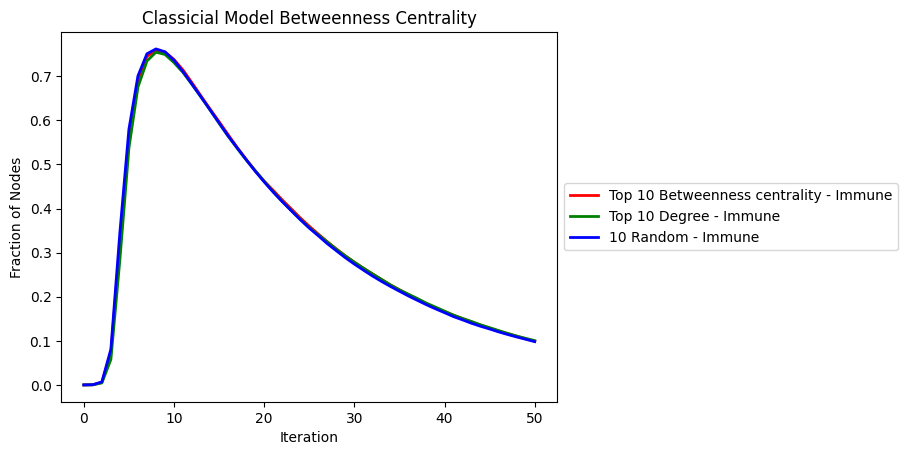

In [91]:
def classical_plot_recovered():
    model_between = ClassicalModel(G)
    beta, gamma = 0.4, 0.05
    model_between.set_parameters(beta, gamma)

    top_between_results, top_degree_results, random_results= plot_immune(
        model_between, 
        title='Classicial Model Betweenness Centrality', 
        iterations=50,
        infected=True,
        # susceptible=True,
        #recovered=True,
        disjoint=True
    )

    # model_degree = ClassicalModel(G)
    # model_degree.set_parameters(beta, gamma)

    # degr_top, degr_bot, degr_rnd = plot_immune_degree(
    #     model_degree, 
    #     title='Classicial Model Degree', 
    #     iterations=50,
    #     infected=True,
    #     # susceptible=False,
    #     #recovered=True,
    #     #disjoint = True
    # )
    return top_between_results, top_degree_results, random_results
classical_top_between_results_R, classical_top_degree_results_R, random_results_R = classical_plot_recovered()